# Предобработка текста, создание и обработка словаря

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from typing import List
from collections import Counter
from itertools import chain

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

# Bert
import torch
from transformers import BertTokenizer, BertModel

# gensim
import pickle
from gensim.models import Word2Vec
import umap
import numpy as np
import seaborn as sns

# Most popular words
from tensorboardX import SummaryWriter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('data/train_40k.csv')
df = pd.DataFrame({'text': df['Text']})
print(df.shape)
df.head(5)

(40000, 1)


,text
0,The description and photo on this product need...
1,This was a great book!!!! It is well thought t...
2,"I am a first year teacher, teaching 5th grade...."
3,I got the book at my bookfair at school lookin...
4,Hi! I'm Martine Redman and I created this puzz...


In [3]:
def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

texts = df.text.tolist()
vocab = build_vocab(texts)
print(len(vocab))
list(vocab.items())[:20]

150693


[('The', 16182),
 ('description', 268),
 ('and', 94682),
 ('photo', 89),
 ('on', 23067),
 ('this', 39382),
 ('product', 8069),
 ('needs', 609),
 ('to', 82965),
 ('be', 13184),
 ('changed', 310),
 ('indicate', 39),
 ('is', 52150),
 ('the', 136165),
 ('BuffalOs', 1),
 ('version', 592),
 ('of', 46364),
 ('beef', 59),
 ('jerky.', 12),
 ('This', 10935)]

In [4]:
# удалим спецсимволы

is_allowed_char = lambda c: c.isalpha() or c == ' '

def preprocess_text(text: str) -> str:
    text = text.lower()
    text = ''.join(list(filter(is_allowed_char, text)))
    return text

texts = [preprocess_text(text) for text in df.text.tolist()]
vocab = build_vocab(texts)
print(len(vocab))
list(vocab.items())[:20]

73171


[('the', 153734),
 ('description', 355),
 ('and', 97871),
 ('photo', 123),
 ('on', 24753),
 ('this', 52538),
 ('product', 11903),
 ('needs', 726),
 ('to', 84350),
 ('be', 13757),
 ('changed', 364),
 ('indicate', 43),
 ('is', 53270),
 ('buffalos', 1),
 ('version', 783),
 ('of', 47044),
 ('beef', 86),
 ('jerky', 89),
 ('was', 24982),
 ('a', 81277)]

In [5]:
eng_stopwords = stopwords.words('english')
is_stopword = lambda word: word not in eng_stopwords

# Исключаем бессмысленные для анализа слова
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = ''.join(list(filter(is_allowed_char, text)))
    text = ' '.join(list(filter(is_stopword, text.split())))
    return text


texts = [preprocess_text(text) for text in df.text.tolist()]
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(30)

73032


[('one', 14870),
 ('like', 12187),
 ('product', 11903),
 ('great', 11305),
 ('would', 10808),
 ('use', 9952),
 ('get', 9395),
 ('good', 8020),
 ('really', 7707),
 ('time', 7669),
 ('well', 7167),
 ('little', 7022),
 ('love', 6934),
 ('also', 6647),
 ('dont', 6625),
 ('much', 6533),
 ('old', 6510),
 ('bought', 6437),
 ('used', 5988),
 ('even', 5886),
 ('toy', 5771),
 ('first', 5374),
 ('hair', 5295),
 ('got', 4773),
 ('still', 4623),
 ('im', 4598),
 ('using', 4556),
 ('back', 4495),
 ('buy', 4404),
 ('put', 4324)]

In [6]:
sorted(vocab.keys())[11239:11255]

['chucks',
 'chug',
 'chugga',
 'chugged',
 'chugging',
 'chugs',
 'chumming',
 'chump',
 'chun',
 'chuncks',
 'chung',
 'chunk',
 'chunkaroo',
 'chunked',
 'chunkgreat',
 'chunkier']

In [7]:
stemmer = PorterStemmer()

for word in sorted(vocab.keys())[11239:11255]:
    print('%15s %s' % (word, stemmer.stem(word)))

         chucks chuck
           chug chug
         chugga chugga
        chugged chug
       chugging chug
          chugs chug
       chumming chum
          chump chump
           chun chun
        chuncks chunck
          chung chung
          chunk chunk
      chunkaroo chunkaroo
        chunked chunk
     chunkgreat chunkgreat
       chunkier chunkier


In [8]:
lemmatizer = WordNetLemmatizer()

for word in sorted(vocab.keys())[11239:11255]:
    print('%15s %s' % (word, lemmatizer.lemmatize(word)))

         chucks chuck
           chug chug
         chugga chugga
        chugged chugged
       chugging chugging
          chugs chug
       chumming chumming
          chump chump
           chun chun
        chuncks chuncks
          chung chung
          chunk chunk
      chunkaroo chunkaroo
        chunked chunked
     chunkgreat chunkgreat
       chunkier chunkier


In [9]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = ''.join(list(filter(is_allowed_char, text)))
    text = ' '.join(list(filter(is_stopword, text.split())))
    text = ' '.join(list(map(stemmer.stem, text.split())))
    return text


texts = []
for text in tqdm(df.text.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(10)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [01:07<00:00, 594.49it/s]


57942


[('use', 21406),
 ('one', 16044),
 ('like', 14166),
 ('product', 13901),
 ('love', 12910),
 ('get', 12899),
 ('great', 11320),
 ('would', 10808),
 ('work', 9912),
 ('time', 9630)]

## Bert

In [10]:
model_bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def make_word_embedding(text: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens]).detach()
    segments_tensors = torch.tensor([segments_ids]).detach()
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    last_layer_embs = outputs[2][-1]
    sentense_embedding = last_layer_embs.squeeze(0).sum(dim=0)
    
    return sentense_embedding

## gensim

In [12]:
pickle.dump(df['text'], open('data/all_texts.pickle', 'wb'))
comms = pickle.load(open('data/all_texts.pickle', 'rb'))

print(len(comms))
comms[1:10]

40000


1    This was a great book!!!! It is well thought t...
2    I am a first year teacher, teaching 5th grade....
3    I got the book at my bookfair at school lookin...
4    Hi! I'm Martine Redman and I created this puzz...
5    My eight year old loves this game, whenever he...
6    The real joy of this movie doesn't lie in its ...
7    Okay, Tim Burton is genuine. He haunts you wit...
8    Boundaries, along with counseling, has given m...
9    120 colors? I say 120 sticks of fun! And a fre...
Name: text, dtype: object

In [13]:
drop_not_letters = lambda s: ''.join(list(filter(lambda c: c.isalpha() or c == ' ', s)))

comms = [drop_not_letters(comm.lower()) for comm in comms]

sentences = [comm.split() for comm in comms]

In [14]:
from gensim.models import Word2Vec

model_gensim = Word2Vec(sentences=sentences,
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42, 
                 min_count=1
)

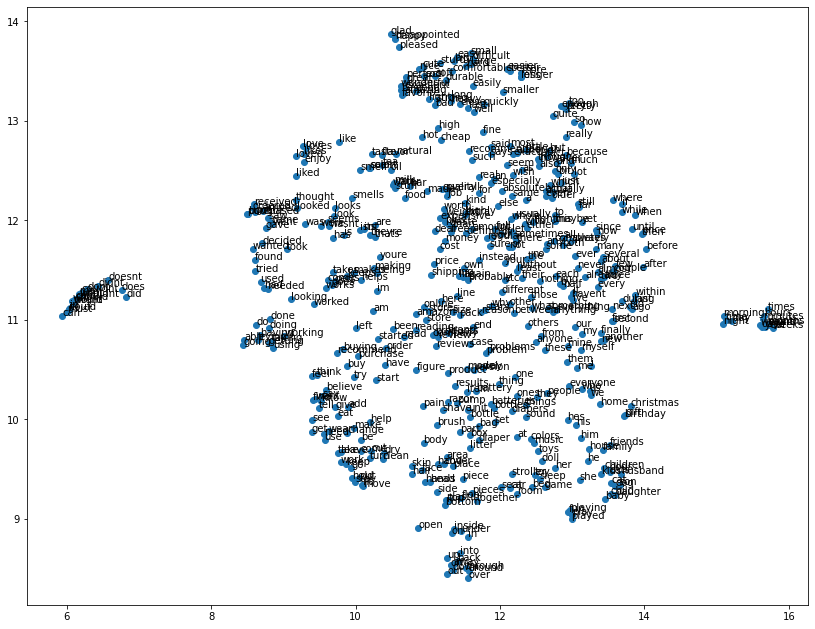

In [15]:
points = umap.UMAP(random_state=32).fit_transform(model_gensim.wv.vectors[:500])
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(model_gensim.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [16]:
def visualize_vec(v, name):
  mx = np.amax(v)
  mn = np.amin(v)
  plt.rcParams['figure.figsize'] = (20, 1)
  fig, ax = plt.subplots()
  ax.tick_params(left=False, bottom=False)
  ax.set_title(name)
  sns.heatmap([v], cmap=sns.color_palette("seismic"), yticklabels=False, xticklabels=False, cbar= False)

In [17]:
def add_vec(v1, v2):
  res = []
  for i in range(0, len(v1)):
    res.append(v1[i] + v2[i])
  return res

def neg_vec(v1, v2):
  res = []
  for i in range(0, len(v1)):
    res.append(v1[i] - v2[i])
  return res    

## gensim operations

In [18]:
def get_gensim_vec(name):
  return model_gensim.wv[name]

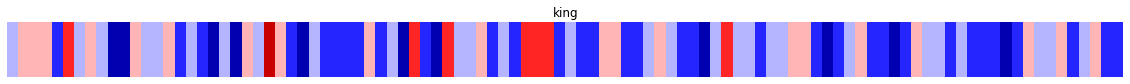

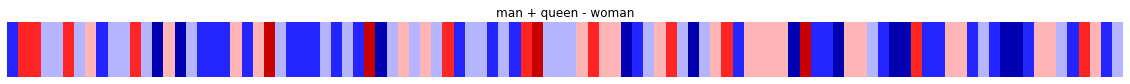

In [19]:
genism_pl_min = model_gensim.wv.most_similar(positive=['queen', 'man'], negative=['woman'])[0][0]
visualize_vec(get_gensim_vec(genism_pl_min), genism_pl_min)
visualize_vec(neg_vec(add_vec(get_gensim_vec('man'), get_gensim_vec('queen')), get_gensim_vec('woman')), 'man + queen - woman')

In [20]:
model_gensim.wv.most_similar('apple')

[('rose', 0.9144607186317444),
 ('mint', 0.9044600129127502),
 ('almond', 0.9033203125),
 ('lime', 0.90262371301651),
 ('cherry', 0.9021539688110352),
 ('mango', 0.8993111848831177),
 ('rice', 0.8979395627975464),
 ('raspberry', 0.8965123295783997),
 ('blueberry', 0.8961296677589417),
 ('ginger', 0.8905263543128967)]

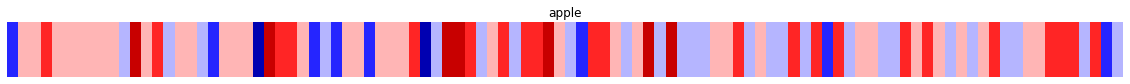

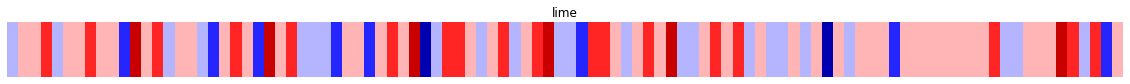

In [21]:
visualize_vec(get_gensim_vec('apple'), 'apple')
visualize_vec(get_gensim_vec('lime'), 'lime')

In [22]:
model_gensim.wv.most_similar('hotel', topn=62870)[-10:]

[('problematical', 0.09797503054141998),
 ('junkyard', 0.0979597419500351),
 ('giftwhen', 0.09794263541698456),
 ('triehope', 0.09792840480804443),
 ('overturn', 0.09790579229593277),
 ('swill', 0.09789421409368515),
 ('doublemetalthingied', 0.0978941097855568),
 ('carryingthanks', 0.09784341603517532),
 ('saveamazon', 0.0978173241019249),
 ('onceday', 0.09781531244516373)]

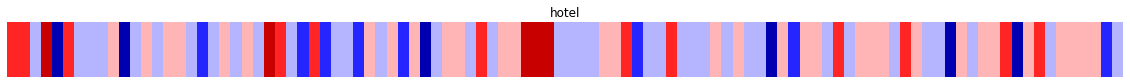

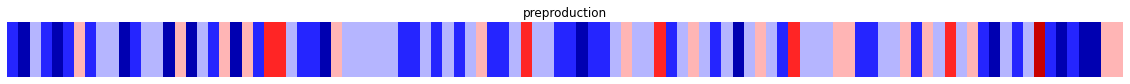

In [23]:
visualize_vec(get_gensim_vec('hotel'), 'hotel')
visualize_vec(get_gensim_vec('preproduction'), 'preproduction')

## Bert operations

In [24]:
def get_bert_vec(name):
  return make_word_embedding(name).cpu().detach().numpy()

def get_bert_most_similar(name):
  vec = get_bert_vec(name)
  return get_bert_most_similar_vec(vec)

def get_bert_most_similar_vec(vec):
  ans = ''
  mx = -100
  first_5k = vocab.most_common(5000)
  words = list(zip(*first_5k))[0]
  for word in tqdm(words):
    word_vec = get_bert_vec(word)
    result = np.dot(vec, word_vec) / (np.linalg.norm(vec) * np.linalg.norm(word_vec))  
    if result > mx:
      print('\ncurr word is {}'.format(word))
      mx = result
      ans = word
  return ans   

In [25]:
some_word = get_bert_most_similar_vec(neg_vec(add_vec(get_bert_vec('queen'), get_bert_vec('man')), get_bert_vec('woman')))

  0%|                                                                                 | 4/5000 [00:00<05:10, 16.09it/s]


curr word is use

curr word is like


  0%|▏                                                                                | 8/5000 [00:00<05:15, 15.82it/s]


curr word is love


  0%|▏                                                                               | 14/5000 [00:00<05:12, 15.96it/s]


curr word is good


  0%|▎                                                                               | 22/5000 [00:01<05:09, 16.07it/s]


curr word is also


 23%|█████████████████▊                                                            | 1140/5000 [01:15<04:09, 15.46it/s]


curr word is man


 54%|██████████████████████████████████████████▏                                   | 2706/5000 [03:06<02:31, 15.13it/s]


curr word is queen


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:00<00:00, 13.87it/s]


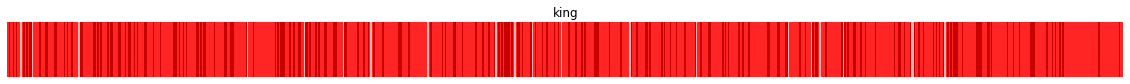

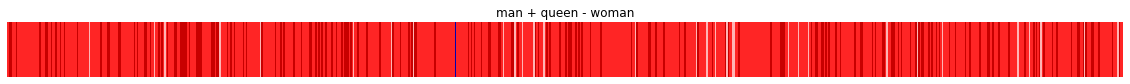

In [26]:
visualize_vec(get_bert_vec('king'), 'king')
visualize_vec(neg_vec(add_vec(get_bert_vec('queen'), get_bert_vec('man')), get_bert_vec('woman')), 'man + queen - woman')

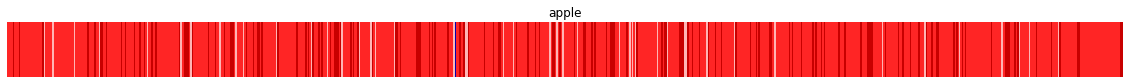

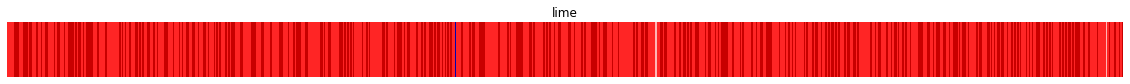

In [27]:
visualize_vec(get_bert_vec('apple'), 'apple')
visualize_vec(get_bert_vec('lime'), 'lime')

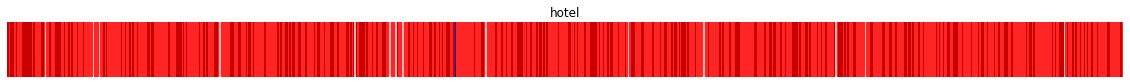

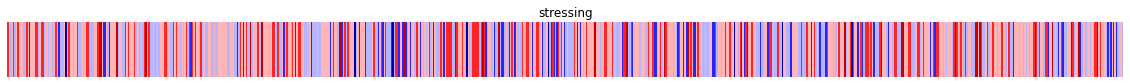

In [28]:
visualize_vec(get_bert_vec('hotel'), 'hotel')
visualize_vec(get_bert_vec('stressing'), 'stressing')

## Most popular 3000

In [29]:
texts_embs = []

most_popular = vocab.most_common(3000)
words = list(zip(*most_popular))[0]

for word in tqdm(words):
    emb = make_word_embedding(word).cpu().detach().numpy()
    texts_embs.append(emb)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:53<00:00, 17.28it/s]


In [30]:
writer = SummaryWriter()
writer.add_embedding(texts_embs,
                     metadata=words)
writer.close()

In [32]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8900), started 0:16:52 ago. (Use '!kill 8900' to kill it.)